In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('wine.csv')
df.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
df.shape

(6497, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


- alcohol : 알코올 도수
- sugar : 당도
- ph : pH 산성도 값
- class : 타깃값 (0.0 - 레드와인, 1.0 - 화이트와인)

In [5]:
df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


- 로지스틱 먼저 돌려보기

In [5]:
x = df.drop('class', axis=1)
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   test_size=0.2,
                                                   random_state=4)

x_train.shape, x_test.shape

((5197, 3), (1300, 3))

In [6]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

logi = LogisticRegression()
logi.fit(scaled_train, y_train)
print(logi.score(scaled_train, y_train))
print(logi.score(scaled_test, y_test))

0.7787184914373677
0.7830769230769231


In [7]:
logi.coef_, logi.intercept_

(array([[ 0.51097693,  1.65039668, -0.69213707]]), array([1.78891743]))

In [11]:
x_train.columns

Index(['alcohol', 'sugar', 'pH'], dtype='object')

In [8]:
logi.predict_proba(scaled_test)

array([[0.09164063, 0.90835937],
       [0.57645552, 0.42354448],
       [0.66393476, 0.33606524],
       ...,
       [0.01176734, 0.98823266],
       [0.13476526, 0.86523474],
       [0.15305585, 0.84694415]])

In [9]:
logi.decision_function(scaled_test)

array([ 2.29376531, -0.30823964, -0.68087859, ...,  4.43059065,
        1.85946643,  1.71083189])

In [10]:
from scipy.special import expit # 이중 분류 
expit(logi.decision_function(scaled_test))

array([0.90835937, 0.42354448, 0.33606524, ..., 0.98823266, 0.86523474,
       0.84694415])

In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, logi.decision_function(scaled_test))
# roc_auc_score(y_test, logi.predict_proba(scaled_test)[:. 1]) 

0.8408481724461105

- 로지스틱 회귀 모델은 설명력이 좋지 않음 (이해하기 어려움)
- sugar가 도대체 어느정도의 영향력을 가지는지를 설명 불가
    - 왜 저런 계수값이 나왔는지 이해하기 어려움.
    - 그냥 그저 알코올 도수와 당도가 높을수록, ph가 낮을수록 화이트와인일 가능성이 높음. 
    - 만약에 다항특성(PolynomialFeatures)과 하이퍼파라미터 튜닝이 추가되면 더욱더 설명하기 어려운 모델이 됨.
    
- 금융권에서는 특히 설명력이 좋은 decision tree 같은 모델이 더 자주 쓰임. 

# 의사 결정 나무 (Decision Tree)

<img src='decision_tree.png'>

- 의의
    - 한번에 하나씩의 독립변수를 사용하여 예측 가능한 규칙들의 집합을 생성하는 알고리즘 
    - 질문을 던져서 대상을 좁혀나가는 스무고개와 비슷한 개념 
    - 분류와 회귀 모두 적용 가능함.
        - 범주형 데이터, 연속형 데이터 모두 예측 가능
        
- 장점
    - 1) 다른 지도학습 기법들에 비해 해석이 쉽다. (설명력이 좋다)
        - 왜 모델이 no라고 판단을 내렸는지 명확, 어떻게 되면 yes 되는지도
    - 2) 유용한 독립변수를 파악 가능
        - 분류 성능이 좋은 feature가 보통 가장 먼저 쓰임. 
    - 3) 선형성, 정규성, 등분산성 등 수학적 가정이 불필요한 "비모수적 모형"임. 
    - 4) 스케일링을 할 필요가 없다. 
        - 스케일링이 의사결정나무 알고리즘에 아무런 영향을 주지 않음. 
        
- 단점
    - 1) 성능이 떨어지는 경우가 많다.
    - 2) 분류 기준값의 경계선 주변의 자료에서는 오차가 클 수 있다. 
    - 3) 각 예측변수의 효과를 파악하기 어렵다. (=로지스틱 회귀)
    - 4) 예측이 불안정할 수 있다.

In [13]:
# from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(random_state=4)

# 결정나무는 스케일링 필요없지만, 
# 일부러 스케일링된 데이터로 학습 
dt.fit(scaled_train, y_train)

print(dt.score(scaled_train, y_train))
print(dt.score(scaled_test, y_test))

0.9973061381566288
0.8761538461538462


# 시각화

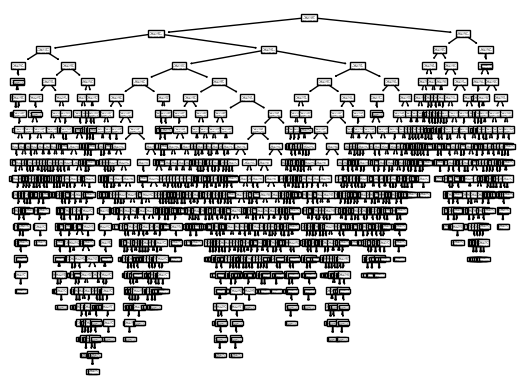

In [14]:
plt.figure()

plot_tree(dt)

plt.show()
# 포도송이들 ... 

- 모델이 너무 복잡하기 때문에 트리의 깊이를 제한해서 출력할 필요가 있음.
    - max_depth : 루트 노드를 제외하고 더 확장하여 그릴 깊이 
    - filled : 클래스에 맞게 색을 칠함. 
    - feature_names : 특성의 이름 전달

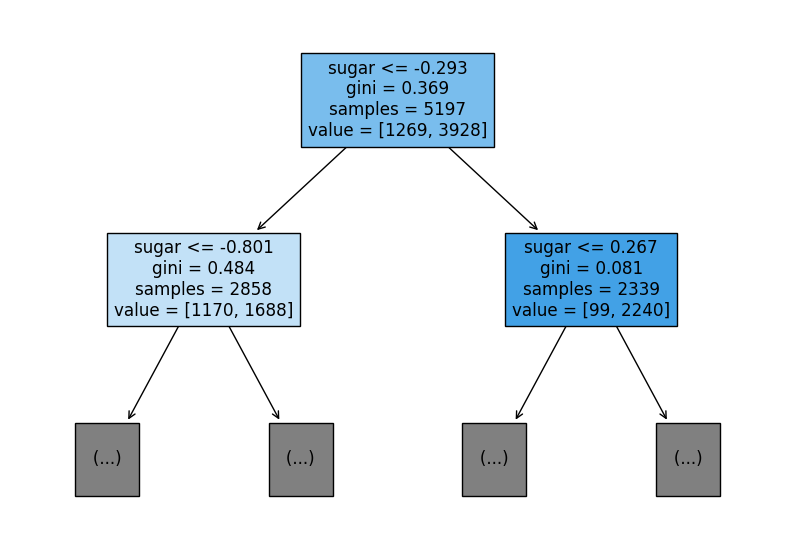

In [15]:
plt.figure(figsize=(10,7))

plot_tree(dt, max_depth=1, filled=True, 
          feature_names=['alcohol', 'sugar', 'pH'])

plt.show()

# 시각화 해석 방법 

- 맨 위의 노드를 root node, 맨 아래 노드를 leaf node라고 함. 

1. 루트 노드는 sugar 가 -0.293 이하인지 질문 
     - 각 데이터 샘플의 sugar가 -0.293 이하이면 왼쪽 가지로 이동 
     - 그렇지 않으면 오른쪽 가지로 이동 
     - 루트 노드의 총 샘플 수는 5197개
         - 이 중에서 음성 클래스(레드 와인)은 1269개
         - 양성 클래스(화이트 와인)은 3928개
         
2. 왼쪽 노드는 sugar가 -0.801 이하인지 질문
    - yes는 왼쪽 가지, no는 오른쪽 가지로 이동
    - 노드의 총 샘플 수는 2858개
        - 음성 클래스와 양성 클래스 개수는 각각 1170, 1688개
        
3. 오른쪽 노드는 sugar가 0.267 이하인지 질문 
    - 노드의 총 샘플 수는 2339개
        - 음성 클래스와 양성 클래스 개수는 각각 99개, 2240개 
        
        
- 왼쪽 노드는 색깔이 더 연해지고 오른쪽 노드는 더 진한 파랑이 됨. 
    - 양성 클래스의 비율이 높아질수록 파란색으로 진하게 됨.
    - 음성 클래스의 비율이 높아질수록 빨간색으로 진하게 됨.
    
- 예측 방법은 리프 노드에서 가장 많은 클래스가 예측 클래스가 됨. 
    - 만약에 이 단계에서 성장을 멈춘다면 왼쪽 노드에 도달한 샘플과 오른쪽 노드에 도달한 샘플 모두 양성 클래스로 예측됨. 
    
- 불순도
    - 불순한 데이터들이 섞여있는 정도 
    - "Gini impurity" (지니 불순도)
    - DecisionTreeClassifier의 criterion 매개변수의 기본값이 gini
    - criterion
        - 노드에서 데이터를 분할할 기준
        - 지니 불순도 계산식
            - 지니 불순도 = 1 - (음성 클래스 비율^2 + 양성 클래스 비율^2)
                - 예) 1 - ((1269/5197)^2 + (3928/5197)^2) = 0.3691...
    - 최악의 불순도
        - 1:1로 섞여 있을 경우 
        - 1 - ((0.5)^2 + (0.5)^2) = 0.5
    - 순수 노드 지니 불순도
        - 1 - ((0/100)^2 + (100/100)^2) = 0.0
        
- 따라서 의사결정나무 모델은 parent node와 child node의 불순도 차이가 가능한 크도록 트리를 성장시킴. 
    - 불순도의 차이
        - 부모의 불순도 - (왼쪽 노드 샘플 수/부모의 샘플 수) * 왼쪽 노드 불순도 - (오른쪽 노드 샘플 수/부모의 샘플 수) * 오른쪽 노드 불순도
        - 부모의 불순도에서, 왼쪽 노드 비율만큼 불순도 빼고, 오른쪽 노드 비율만큼 불순도 빼줌.
    - 이런 차이를 information gain (정보 이득)이라고 함.
        - 의사결정나무 알고리즘은 정보 이득이 최대가 되도록 데이터를 나누어 줌. 
            - 이때 사용하는 기준이 "지니 불순도" 
            - 사이킷런에서 제공하는 또다른 불순도 기준으로는 "엔트로피 불순도"가 있음. 
        - 노드를 순수하게 나눌수록 정보 이득은 커짐. 
            - 자식 노드의 불순도가 낮을수록 (지니 불순도가 낮을수록)
        

In [18]:
# 부모노드와 자식노드의 불순도 차이 계산
0.369 - (2858/5197)*0.484 - (2339/5197)*0.081

0.06637714065807196

In [17]:
# 루트 노드의 지니 불순도 계산 
1 - ((1269/5197)**2 + (3928/5197)**2)

0.3691115739313051

- 머신러닝 모델은 "블랙박스"와 같음.
- 변별력이 좋은 것 (sugar <= 0.267)을 맨 처음에 쓰지 않은 이유를 알 수 없음. 

# 가지치기

- 깊이에 제한을 두지 않고 무작정 끝까지 자라나는 트리를 만들게 되면 훈련 세트에는 아주 잘 맞지만 테스트 세트에는 적합하지 않은 과대적합 모델이 되어 일반화가 잘 되지 않음. 

- 트리의 성장을 제한하는 방법이 가지치기 
    - 가장 간단한 가지치기 방법은 트리의 최대 깊이를 지정하는 것. 

In [19]:
dt = DecisionTreeClassifier(max_depth=3, random_state=4)
dt.fit(scaled_train, y_train)
print(dt.score(scaled_train, y_train))
print(dt.score(scaled_test, y_test))
# 성능도 떨어지고 과소적합이 되어버림. 

0.8447181065999615
0.8569230769230769


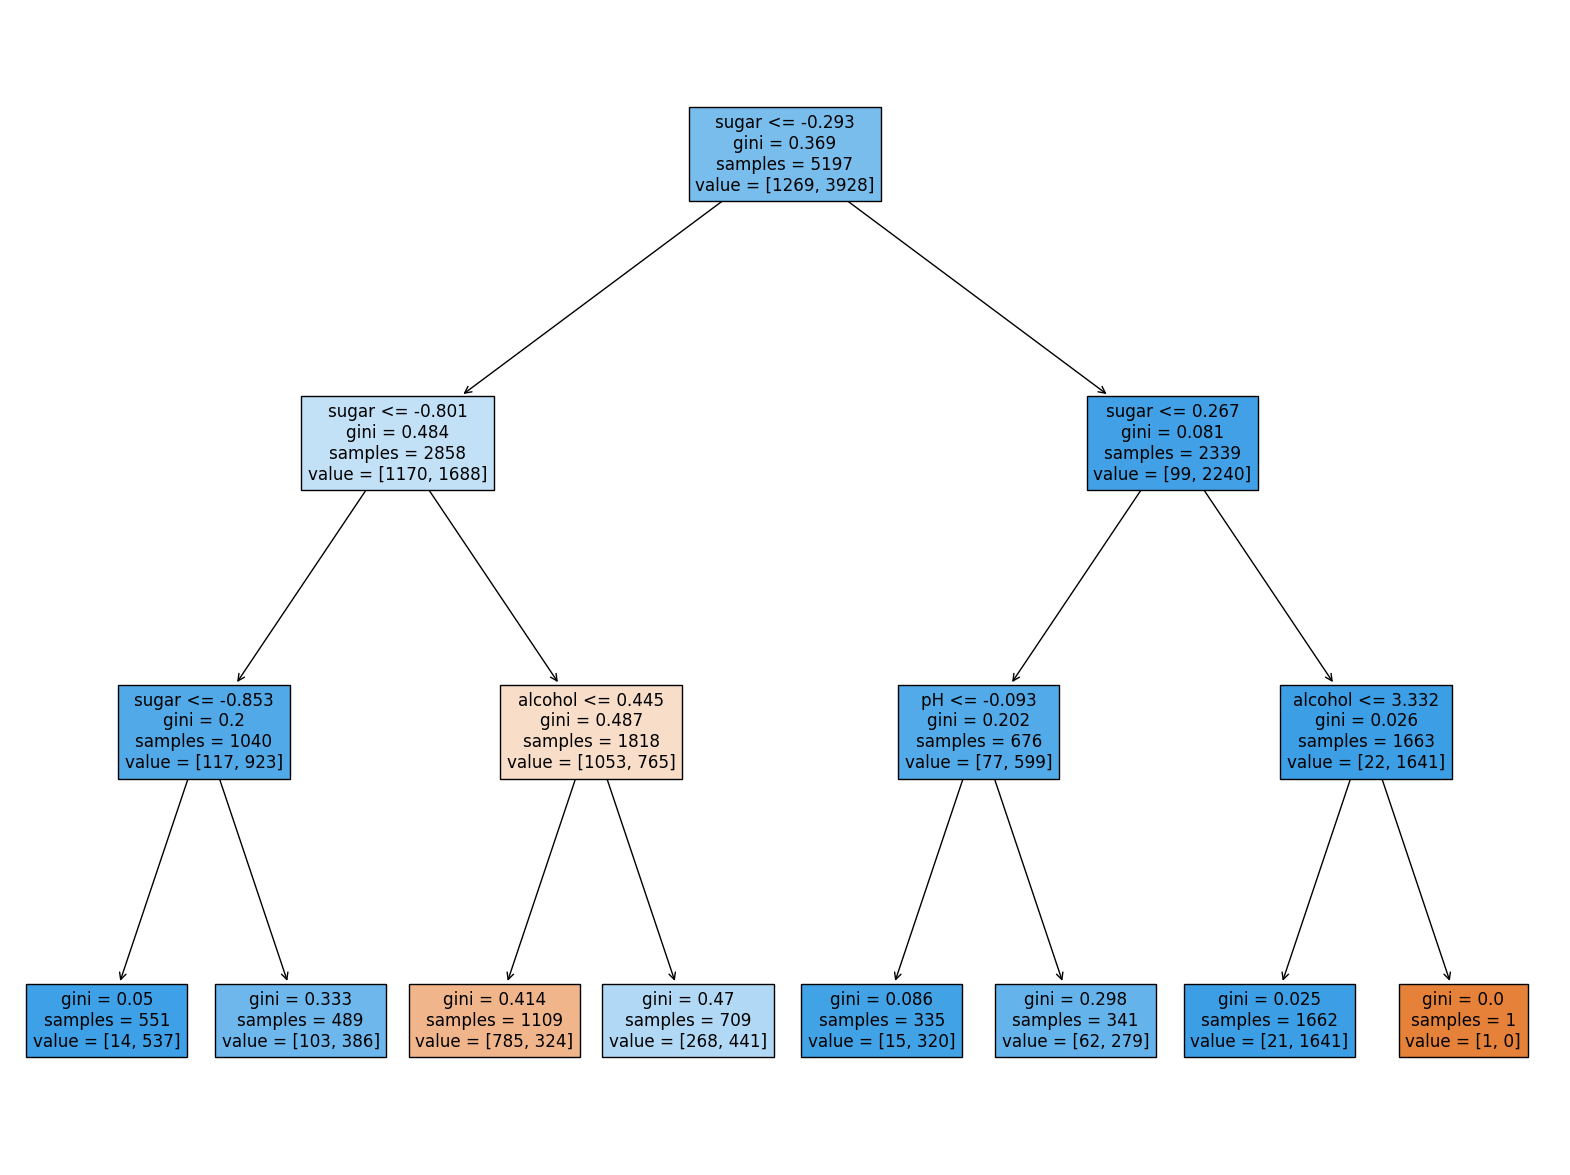

In [20]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

In [21]:
dt = DecisionTreeClassifier(max_depth=3, random_state=4)
# 스케일링 안된 데이터로 
dt.fit(x_train, y_train)
print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.8447181065999615
0.8569230769230769


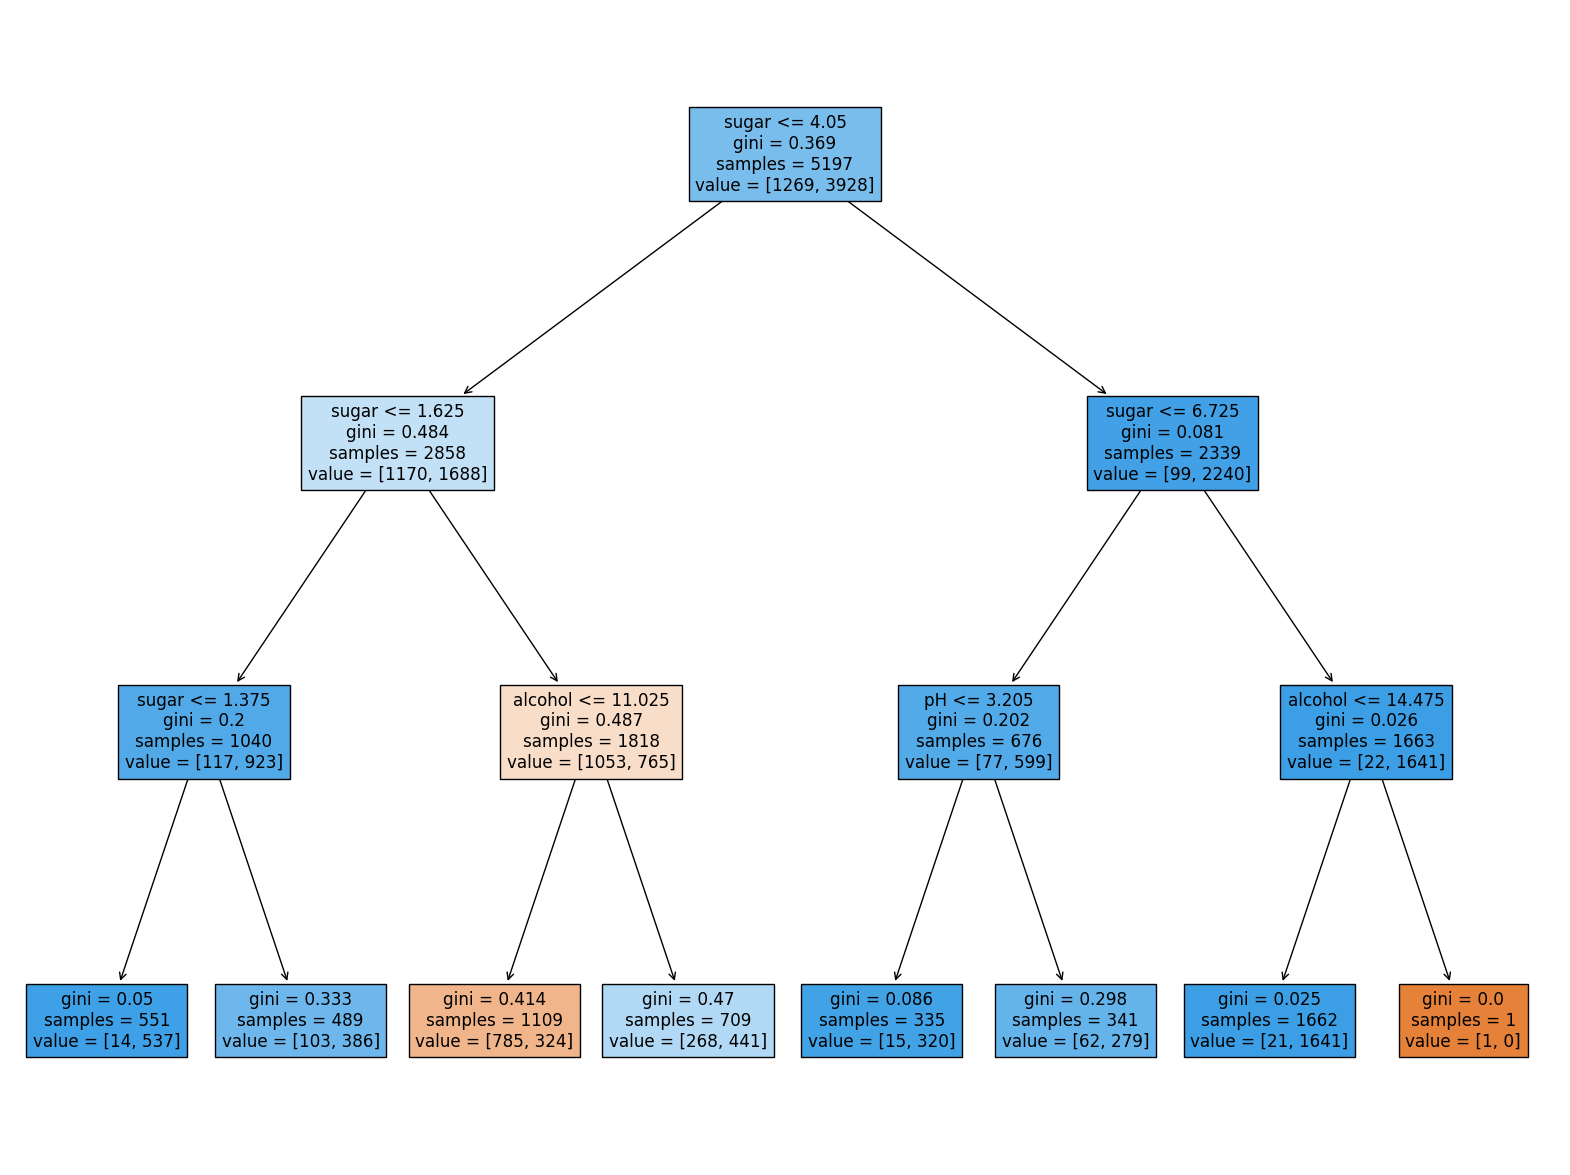

In [22]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

- 굳이 스케일링 하지 않아도, 스케일링 한것과 똑같은 결과를 낸다는 것을 알 수 있음.
    - 아주 미세하게는 차이가 있음 (max_depth =10 으로 더 늘렸을 경우 아주 조금 차이 발생)
- 스케일링 하지 않은 게, 오히려 feature 해석에 더 편리함. 

- 당도가 1.625에서 4.05 사이이고 알코올 도수가 11.025 이하인 것이 레드 와인(0) 

In [23]:
# 특성 중요도 
print(dt.feature_importances_)

[0.12561467 0.86608511 0.00830022]


In [32]:
dt.feature_names_in_

array(['alcohol', 'sugar', 'pH'], dtype=object)

- 특성 중요도 
    - 어떤 특성이 가장 유용한지 나타내는 지표
    - 두 번째 특성인 sugar가 0.87로 가장 높음 --> sugar, alcohol, pH 순서
    - 각 노드의 정보 이득과 전체 샘플에 대한 비율을 곱한 후 특성별로 계산 
    - 특성 중요도를 활용하여 변수 선택에 활용 가능 